In [18]:
# 1. Download the datasets - Boston House pricing, Titanic survivors
# Do we do imputation? - No we skip for this excercise

# https://seaborn.pydata.org/tutorial/axis_grids.html

# 1. Are we doing classification  or regression trees?
#    Use Gini, Entropy gain, Information gain
#    Pruning

In [19]:
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations

from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate


from ucimlrepo import fetch_ucirepo 

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [20]:


def calc_matthews_corrcoef(X):
    """
    Calculate the pair wise matthews corr coeff for all the columns.

    returns a matrix 
    """
    corr_coeff = pd.DataFrame(np.nan, columns=X.columns, index=X.columns)
    
    pairs = list(combinations(X.columns, 2))

    for col in X.columns:
        corr_coeff.loc[col, col] = 1.0

    for col_x, col_y in combinations(X.columns, 2):

        corr_coeff.loc[col_x, col_y] = corr_coeff.loc[col_y, col_x] = matthews_corrcoef(X[col_x], X[col_y])

    return corr_coeff

In [53]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 
  
# metadata 
cdc_diabetes_health_indicators.metadata

# Easy to understand data - => easier to sense check the result of the models
# Has a large data set
# Has mix of binary and integer data
# No missing data points
# The other dataset is coategorical dataset - has missing data
# Classification ouitcome is also binary

# Use phi coefficeint to find correlated data


{'uci_id': 891,
 'name': 'CDC Diabetes Health Indicators',
 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators',
 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv',
 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Tabular', 'Multivariate'],
 'num_instances': 253680,
 'num_features': 21,
 'feature_types': ['Categorical', 'Integer'],
 'demographics': ['Sex', 'Age', 'Education Level', 'Income'],
 'target_col': ['Diabetes_binary'],
 'index_col': ['ID'],
 'has_missing_values': 'no',
 'missing_values_symbol

In [22]:
idx = cdc_diabetes_health_indicators['variables']['type'] == 'Integer'
int_cols = cdc_diabetes_health_indicators['variables'].loc[idx, 'name']
int_cols = int_cols.loc[~int_cols.isin(y.columns.tolist() + ['ID'])]

In [23]:
int_cols

5           BMI
15      GenHlth
16     MentHlth
17     PhysHlth
20          Age
21    Education
22       Income
Name: name, dtype: object

In [24]:
idx = cdc_diabetes_health_indicators['variables']['type'] == 'Binary'
bin_cols = cdc_diabetes_health_indicators['variables'].loc[idx, 'name']

# bin_cols.drop(y.names)
bin_cols = bin_cols.loc[~bin_cols.isin(y.columns)]


In [25]:
bin_cols

2                   HighBP
3                 HighChol
4                CholCheck
6                   Smoker
7                   Stroke
8     HeartDiseaseorAttack
9             PhysActivity
10                  Fruits
11                 Veggies
12       HvyAlcoholConsump
13           AnyHealthcare
14             NoDocbcCost
18                DiffWalk
19                     Sex
Name: name, dtype: object

In [26]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

from sklearn.model_selection import StratifiedKFold, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# EDA - on the FULL data set
1. For the binary value to a % plot of distribution - note the ones that are very skewed
2. For the continuous data - do a violin plot distribution  - do we need normalisation here?
3. Do a correlation plot o

<Axes: >

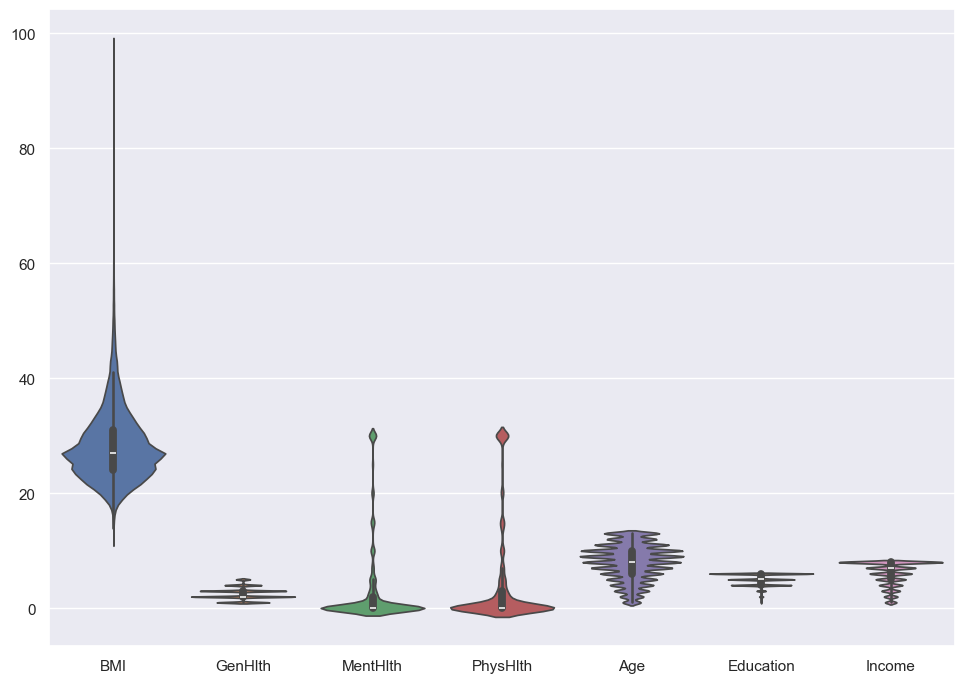

In [27]:
sns.violinplot(X_train[int_cols])

<Axes: >

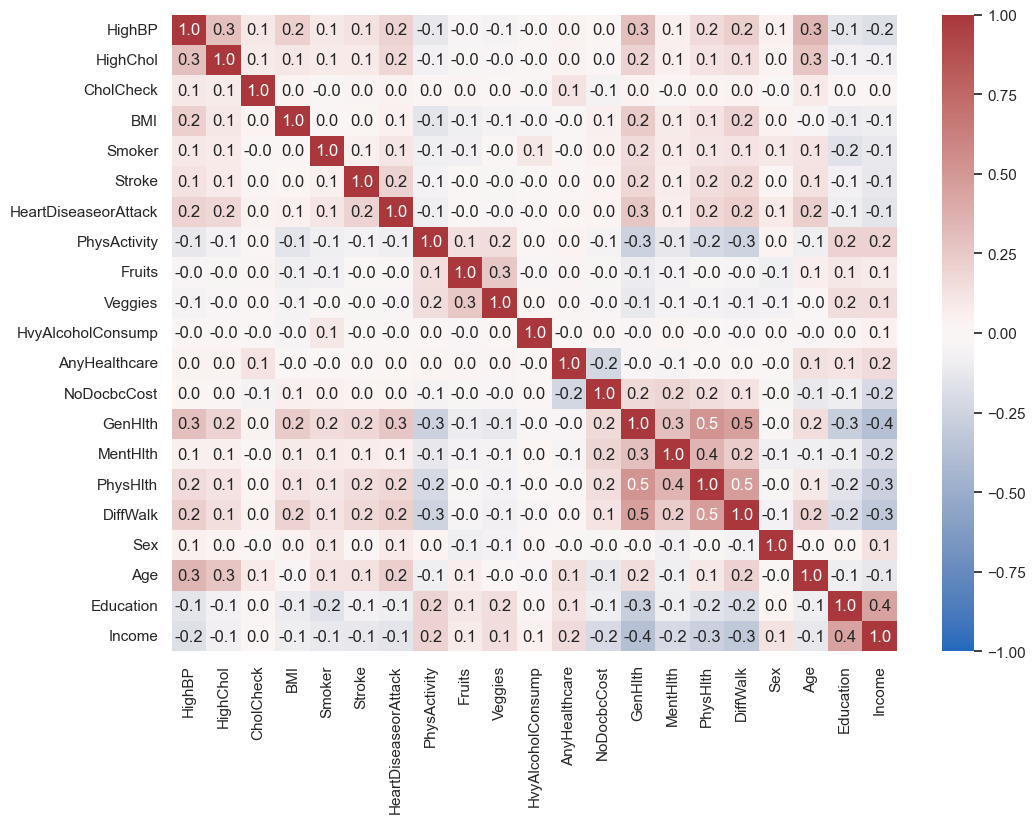

In [28]:
sns.heatmap(X_train.corr(),annot=True, fmt=".1f", vmin=-1, vmax = 1, cmap='vlag')

In [29]:
X_melt = X.melt(id_vars=['Age', 'Sex'], 
                value_vars=['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack'],  
                var_name='metric')

In [30]:
X_melt.head()

,Age,Sex,metric,value
0,9,0,HighBP,1
1,7,0,HighBP,0
2,9,0,HighBP,1
3,11,0,HighBP,1
4,11,0,HighBP,1


In [59]:
def _countplot(x, hue, palette='dark:#4c72b0', **kwargs):
    """
    https://stackoverflow.com/a/44035405/6931113

    x: pd.series
    """
    sns.countplot(x=x, hue=hue, palette=palette, **kwargs)

    
def plot_countplot(X_melt):
    """
        https://stackoverflow.com/a/69813924/6931113
    """
    g = sns.FacetGrid(X_melt, row="Age", col="metric")
    g.map(_countplot, "value", "Sex", order=[0, 1], stat='percent')
    g.set_xticklabels(['No', 'Yes'])
    g.set_titles("Age = {row_name} | metric = {col_name}")
    g.set_axis_labels("", "Percentage")
    # g.fig.subplots_adjust(wspace=.02)
    # g.fig.suptitle('Countplot of X_melt by metric')
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    return ax


<Axes: title={'center': 'Age = 13 | metric = HeartDiseaseorAttack'}>

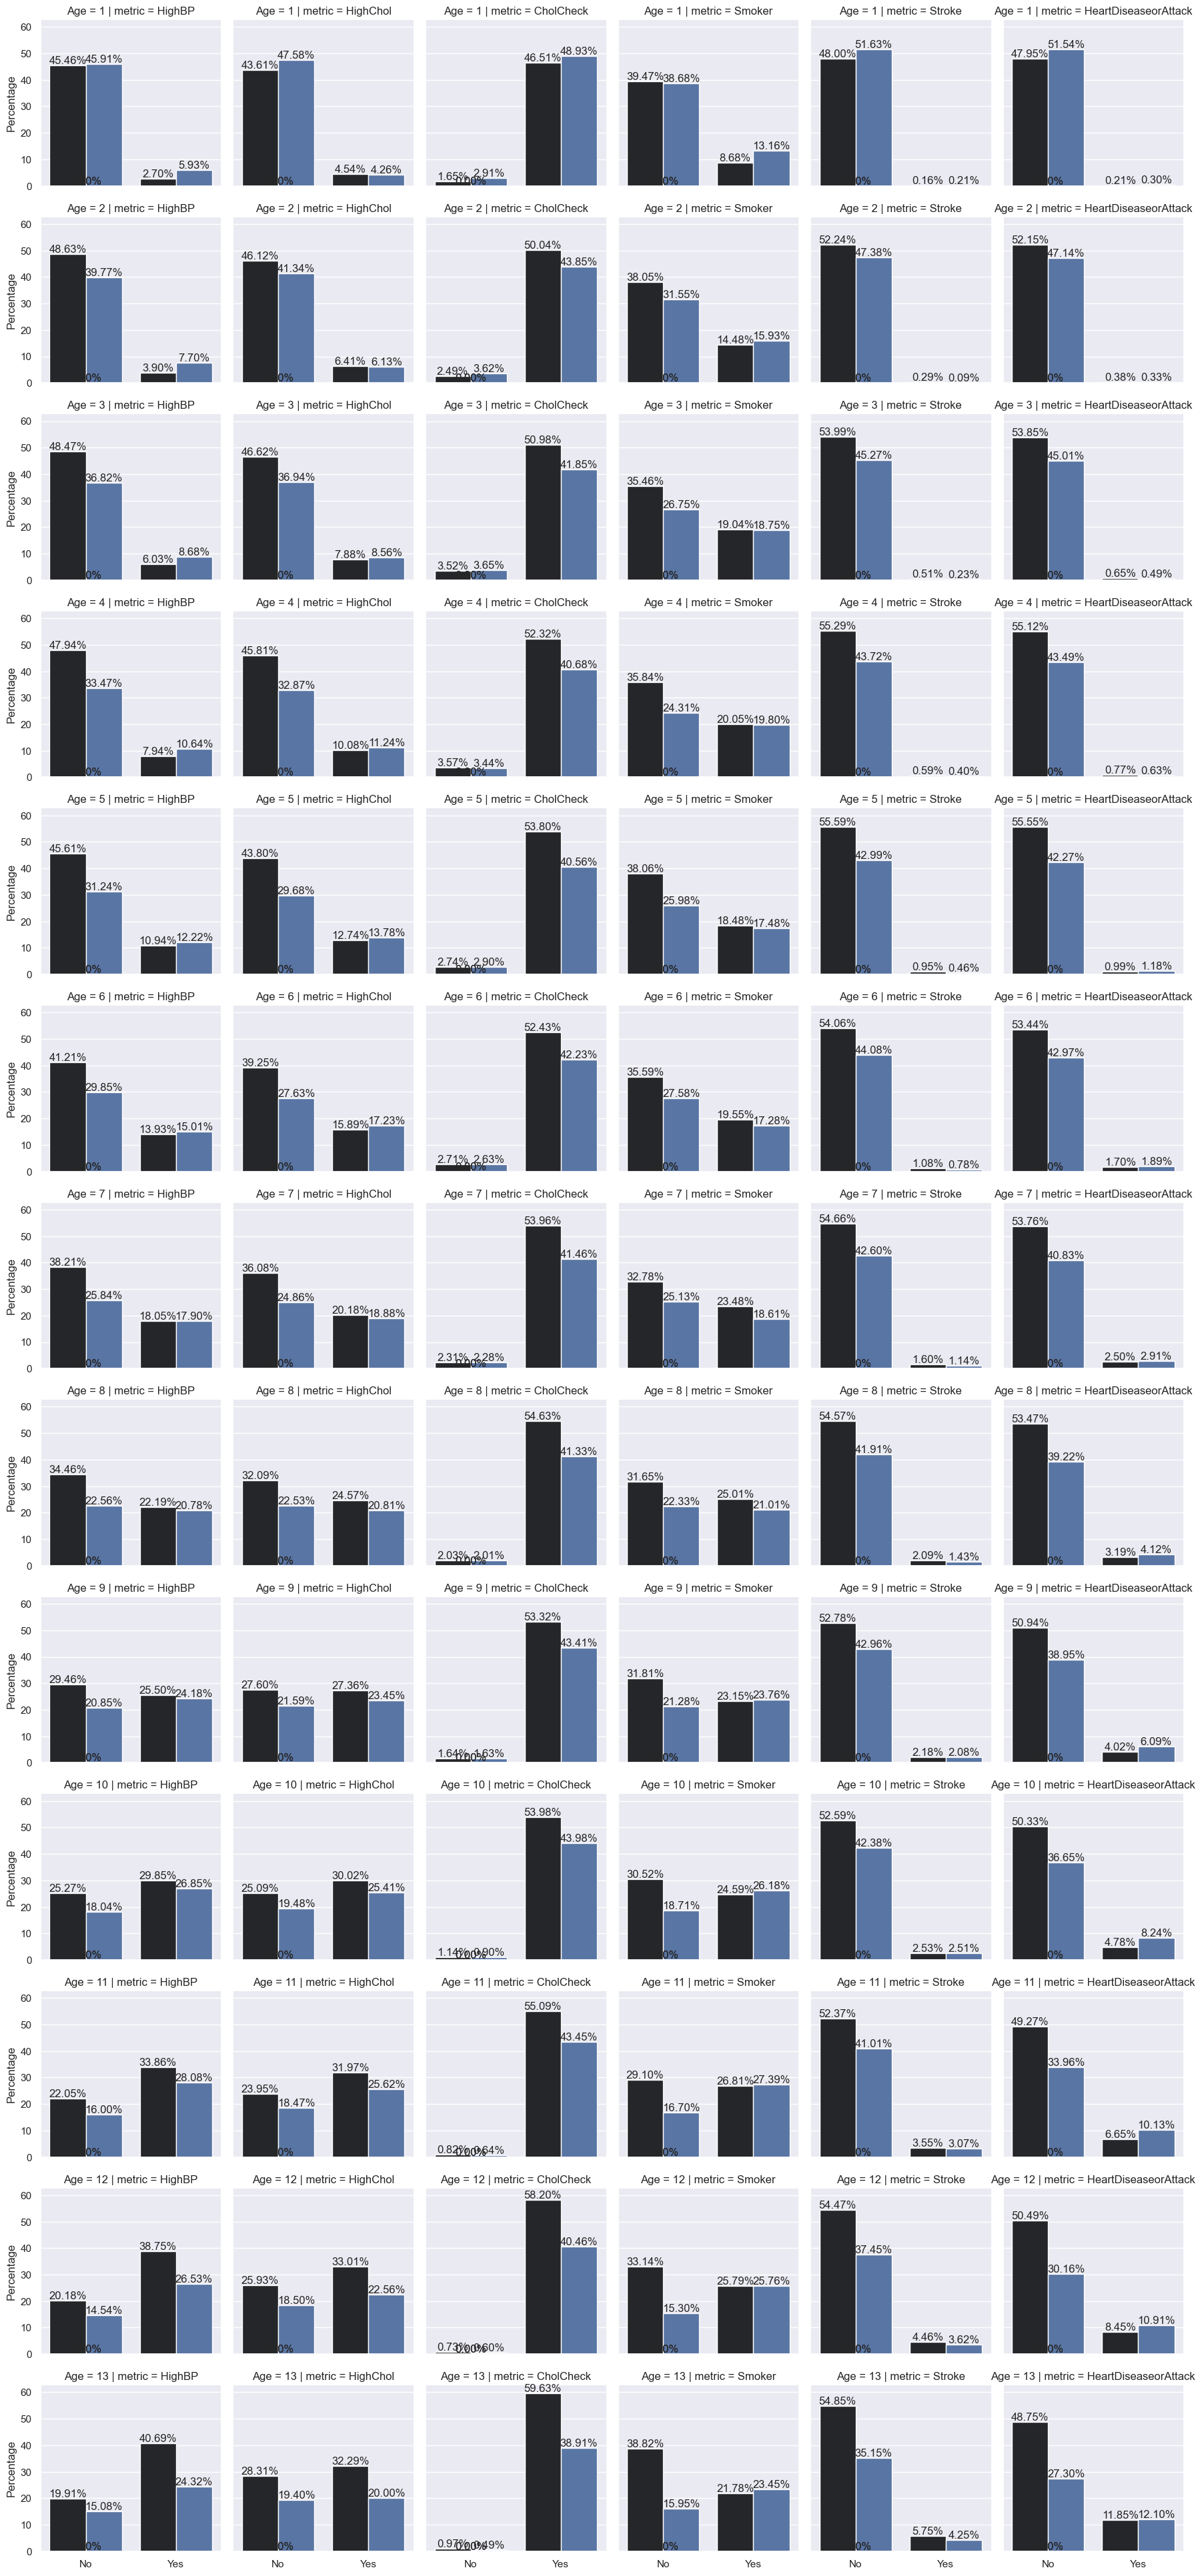

In [60]:
plot_countplot(X_melt)

matplotlib.axes._axes.Axes

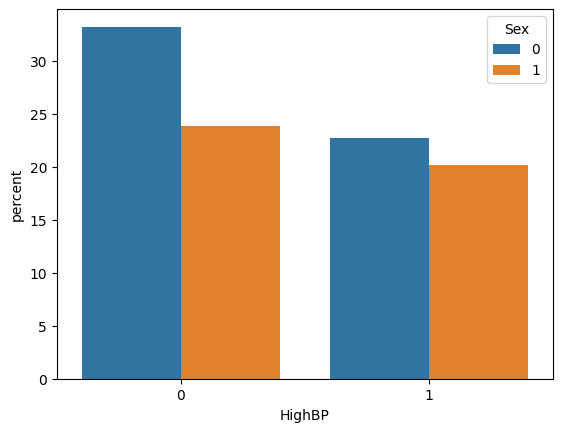

In [22]:
ax = sns.countplot(data=X, x='HighBP', hue='Sex', stat='percent')

In [ ]:
sns.countplot(data=X, x='HighChol', hue='Sex', stat='percent')

In [ ]:
sns.countplot(data=X, x='CholCheck', hue='Sex', stat='percent')

In [ ]:
sns.countplot(data=X, x='Smoker', hue='Sex', stat='percent')

In [ ]:
sns.countplot(data=X, x='Stroke', hue='Sex', stat='percent')

In [ ]:
sns.countplot(data=X, x='Stroke', hue='HeartDiseaseorAttack', stat='percent')

In [ ]:
sns.countplot(data=X, x='Stroke', hue='PhysActivity', stat='percent')

In [ ]:
sns.countplot(data=X, x='Stroke', hue='Fruits', stat='percent')

In [ ]:
sns.countplot(data=X, x='Stroke', hue='Veggies', stat='percent')

In [ ]:
# sns.countplot(X, x='HighBP')
cols = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 
        'DiffWalk', 'Sex', 'Age', 'Education',
       'Income']
g= sns.FacetGrid(X[cols],  row='HighBP', hue='Sex')
g.map(sns.countplot, 'Age')
# sns.countplot(X, x='Fruits', hue='Sex', )

In [ ]:
# relplot
# g = sns.PairGrid(X)
# g.map_diag(sns.scatterplot)
# g.map_upper
# g.map_offdiag(sns.scatterplot)


g = sns.PairGrid(X[['HighBP', 'HighChol', 'Sex']], )
g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)


#### # variable information 
cdc_diabetes_health_indicators.variables